In [2]:
import os
import argparse
import time
import glob
import pickle
import subprocess
import shlex
import io
import pprint
import importlib
from urllib.request import urlopen

import numpy as np
import pandas
import tqdm
import fire

import torch
import torch.nn as nn
import torch.utils.model_zoo
import torchvision
from IPython.display import Image as Img
import cornet

from PIL import Image
Image.warnings.simplefilter('ignore')

np.random.seed(0)
torch.manual_seed(0)

mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])

In [3]:
def get_model(model_size='z'):
    map_location = 'cpu'
    #map_location = None
    model = getattr(cornet, f'cornet_{model_size.lower()}')
    if model_size.lower() == 'r':
        model = model(pretrained=True, map_location=map_location, times=5)
    else:
        model = model(pretrained=True, map_location=map_location)
    model.cpu()
    return model.module

In [4]:
def test(data_path, layer='decoder', sublayer='output', time_step=0, imsize=224):
    """
    Suitable for small image sets. If you have thousands of images or it is
    taking too long to extract features, consider using
    `torchvision.datasets.ImageFolder`, using `ImageNetVal` as an example.

    Kwargs:
        - layers (choose from: V1, V2, V4, IT, decoder)
        - sublayer (e.g., output, conv1, avgpool)
        - time_step (which time step to use for storing features)
        - imsize (resize image to how many pixels, default: 224)
    """
    model = get_model(model_size='s')
    transform = torchvision.transforms.Compose([
                    torchvision.transforms.Resize((imsize,imsize)),
                    torchvision.transforms.ToTensor(),
                    normalize,
                ])
    model.eval()

    def _store_feats(layer, inp, output):
        """An ugly but effective way of accessing intermediate model features
        """
        _model_feats.append(np.reshape(output, (len(output), -1)).numpy())

    try:
        m = model.module
    except:
        m = model
    model_layer = getattr(getattr(m, layer), sublayer)
    model_layer.register_forward_hook(_store_feats)

    model_feats = []
    with torch.no_grad():
        model_feats = []
        fnames = sorted(glob.glob(os.path.join(data_path, '*.*')))
        if len(fnames) == 0:
            raise f'No files found in {data_path}'
        for fname in tqdm.tqdm(fnames):
            try:
                im = Image.open(fname).convert('RGB')
                print(f'Processing file {fname}')
            except:
                raise f'Unable to load {fname}'
            im = transform(im)
            im = im.unsqueeze(0)  # adding extra dimension for batch size of 1
            _model_feats = []
            model(im)
            model_feats.append(_model_feats[time_step])
        model_feats = np.concatenate(model_feats)
    return model_feats

In [4]:
def get_features(data, model_size='s', time_step=0):
    def _store_feats(layer, inp, output):
        """An ugly but effective way of accessing intermediate model features
        """
        _model_feats.append(np.reshape(output, (len(output), -1)).numpy())

    model = get_model(model_size=model_size)
    model.eval()
    model_layer = getattr(getattr(model, layer), sublayer)
    model_layer.register_forward_hook(_store_feats)

    model_feats = []
    with torch.no_grad():
        for im in tqdm.tqdm(data):
            _model_feats = []
            model(np.array([im]))
            model_feats.append(_model_feats[time_step])
        model_feats = np.concatenate(model_feats)
    return model_feats

In [5]:
data_path = 'C:\\Users\\serge\\Desktop\\cornet\\set1'

In [6]:
labels = pickle.load(urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl') )

In [7]:
fnames = sorted(glob.glob(os.path.join(data_path, '*.*')))
print(fnames)


['C:\\Users\\serge\\Desktop\\cornet\\set1\\ILSVRC2012_val_00000011.JPEG', 'C:\\Users\\serge\\Desktop\\cornet\\set1\\ILSVRC2012_val_00000012.JPEG', 'C:\\Users\\serge\\Desktop\\cornet\\set1\\ILSVRC2012_val_00000013.JPEG', 'C:\\Users\\serge\\Desktop\\cornet\\set1\\ILSVRC2012_val_00000014.JPEG', 'C:\\Users\\serge\\Desktop\\cornet\\set1\\ILSVRC2012_val_00000015.JPEG', 'C:\\Users\\serge\\Desktop\\cornet\\set1\\ILSVRC2012_val_00000016.JPEG', 'C:\\Users\\serge\\Desktop\\cornet\\set1\\ILSVRC2012_val_00000017.JPEG', 'C:\\Users\\serge\\Desktop\\cornet\\set1\\ILSVRC2012_val_00000018.JPEG', 'C:\\Users\\serge\\Desktop\\cornet\\set1\\ILSVRC2012_val_00000019.JPEG', 'C:\\Users\\serge\\Desktop\\cornet\\set1\\ILSVRC2012_val_00000020.JPEG', 'C:\\Users\\serge\\Desktop\\cornet\\set1\\ILSVRC2012_val_00000021.JPEG']


In [8]:
from IPython.display import Image as Img

In [9]:
model_size = 's'

In [10]:
model = get_model(model_size)

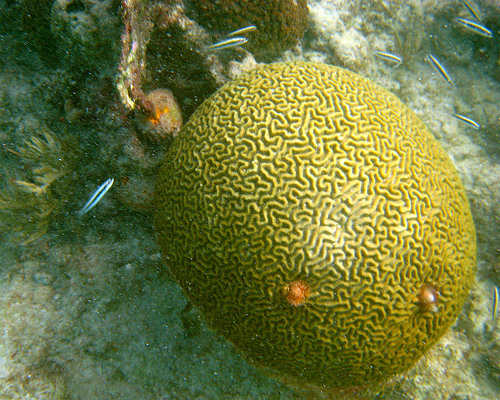

NameError: name 'features' is not defined

In [8]:
for idx, fname in enumerate(fnames):
    display(Img(fname))
    print(labels[features.argmax(axis=1)[idx]])

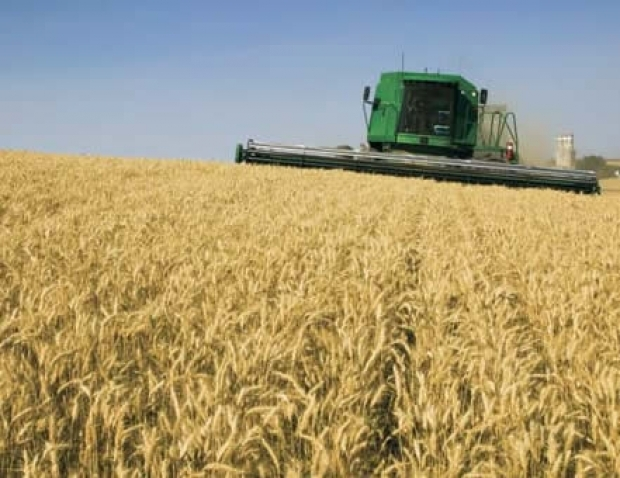

In [119]:
Img('C:\\Users\\serge\\Desktop\\cornet\\set1\\ILSVRC2012_val_00000015.JPEG')

In [11]:
im = Image.open('C:\\Users\\serge\\Desktop\\cornet\\set1\\ILSVRC2012_val_00000015.JPEG').convert('RGB')

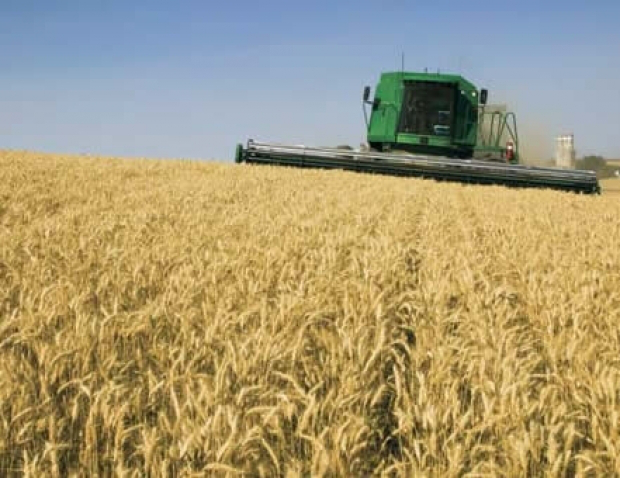

In [12]:
im

In [13]:
transform = torchvision.transforms.Compose([
                    torchvision.transforms.Resize((224,224)),
                    torchvision.transforms.ToTensor(),
                    normalize,
                ])
x = transform(im)

In [14]:
from art.attacks import FastGradientMethod
from art.classifiers import PyTorchClassifier

In [15]:

unnormalize = torchvision.transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

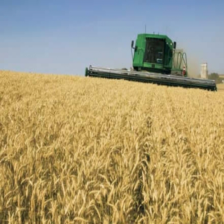

In [16]:
torchvision.transforms.ToPILImage()(unnormalize(transform(im)))

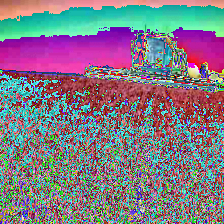

In [17]:
torchvision.transforms.ToPILImage()(x)

In [18]:
model = get_model(model_size='s')

In [19]:
model.eval()

Sequential(
  (V1): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (nonlin1): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (nonlin2): ReLU(inplace=True)
    (output): Identity()
  )
  (V2): CORblock_S(
    (conv_input): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (skip): Conv2d(128, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (norm_skip): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (nonlin1): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, k

In [23]:
model(x.unsqueeze(0))

tensor([[ 6.4678e-01, -2.2378e+00, -7.1635e-01, -1.1132e+00, -1.4110e+00,
         -1.5552e+00, -2.4035e+00, -1.8683e+00, -2.5609e+00,  5.3106e-01,
         -3.3327e+00, -2.8567e+00, -1.3565e+00, -2.8352e+00, -5.3601e-01,
         -3.4077e-01, -2.3710e+00, -2.1641e+00, -1.2501e+00, -2.6096e+00,
         -3.4316e+00,  9.4659e-01, -1.5562e+00,  1.0687e-01, -1.2052e+00,
         -3.3186e+00, -2.5807e+00, -2.8468e+00, -2.7742e+00, -2.6100e+00,
         -2.2886e+00, -2.2965e+00, -2.1727e+00, -1.0416e+00, -7.0794e-01,
         -2.1990e+00, -8.1649e-01, -2.4660e+00, -2.2986e+00, -2.9427e-01,
         -2.0411e+00, -2.1549e+00, -2.5739e-02, -9.3494e-01, -2.1381e+00,
         -6.0918e-01, -8.3002e-01,  1.6566e+00, -1.5567e+00, -2.8663e+00,
         -1.8310e+00,  1.5213e-01, -3.1486e+00, -2.4642e+00, -6.6648e-01,
         -1.4061e+00, -2.6345e+00, -3.6805e+00, -1.8209e+00, -1.0398e+00,
         -3.6931e+00, -2.7168e+00, -1.1065e+00, -2.4357e+00,  2.3868e+00,
          6.5864e-01, -1.2714e+00, -9.

In [20]:
x = transform(im)

In [21]:
x.shape

torch.Size([3, 224, 224])

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# Step 3: Create the ART classifier

classifier = PyTorchClassifier(model=model, loss=criterion,
                               optimizer=optimizer, nb_classes=1000, input_shape=(3,224,224))

In [23]:
X = x.unsqueeze(0)

In [24]:
X = X.numpy()

In [25]:
result = classifier.predict(X)

In [26]:
labels[result.argmax()]

'harvester, reaper'

In [27]:
attack = FastGradientMethod(classifier=classifier, eps=0.1, minimal=True)
x_test_adv = attack.generate(x=X)

# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)

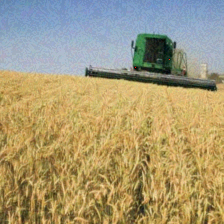

In [28]:
display(torchvision.transforms.ToPILImage()(unnormalize(torch.from_numpy(x_test_adv[0]))))

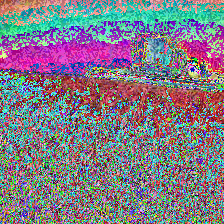

In [29]:
display(torchvision.transforms.ToPILImage()(torch.from_numpy(x_test_adv[0])))

In [37]:
labels[predictions[0].argmax()]

'thresher, thrasher, threshing machine'

In [1]:
from imgaug import augmenters as iaa

In [32]:
aug = iaa.Canny()

In [66]:
adv = unnormalize(torch.from_numpy(x_test_adv[0]))

In [59]:
adv.shape

torch.Size([3, 224, 224])

In [67]:
adv2 = np.moveaxis(adv.numpy(), [0, 1, 2], [2, 0, 1])

In [41]:
adv1 = np.transpose(adv.numpy())

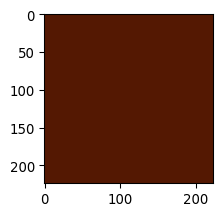

In [46]:
import imgaug as ia
%matplotlib inline
ia.imshow(aug.augment_image(adv1.astype(np.uint8)))

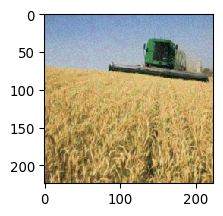

In [69]:
ia.imshow((adv2*255).astype(np.uint8))